In [1]:
import kagglehub
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print("Path to dataset files:", path)

100%|██████████| 312k/312k [00:00<00:00, 475kB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/nayanjain28/cv-dataset/versions/1


In [2]:
!apt-get install -y tesseract-ocr
!tesseract --version
!pip install pdf2image
!pip install opencv-python pytesseract scikit-learn
!apt-get install -y poppler-utils tesseract-ocr
!pip install pytesseract pdf2image opencv-python pillow kagglehub
!apt-get update
!pip install pdf2image pytesseract opencv-python

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
tesseract 4.1.1
 leptonica-1.82.0
  libgif 5.1.9 : libjpeg 8d (libjpeg-turbo 2.1.1) : libpng 1.6.37 : libtiff 4.3.0 : zlib 1.2.11 : libwebp 1.2.2 : libopenjp2 2.4.0
 Found AVX512BW
 Found AVX512F
 Found AVX2
 Found AVX
 Found FMA
 Found SSE
 Found libarchive 3.6.0 zlib/1.2.11 liblzma/5.2.5 bz2lib/1.0.8 liblz4/1.9.3 libzstd/1.4.8
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
The following NEW packages will be installed:
  poppler-utils
0 upgraded, 1 newly installed, 0 to remove and 34 not upgraded.
Need to get 186 kB of archives.
After this operation, 697 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main a

In [3]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")
def clean_and_list_pdfs(folder_path):
    pdf_files = []

    for filename in os.listdir(folder_path):
        original_path = os.path.join(folder_path, filename)

        if not os.path.isfile(original_path):
            continue
        clean_name = filename.strip()
        name_lower = os.path.splitext(clean_name)[0]
        ext_lower = os.path.splitext(clean_name)[1].lower()
        new_filename = name_lower + ext_lower

        if ext_lower == ".pdf":
            if new_filename != filename:
                print(f" Would rename: '{filename}' → '{new_filename}'-[]")
            pdf_files.append(os.path.join(folder_path, filename))

    return pdf_files
def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(binary, config=config)

        count_e = text.lower().count('e')
        print(f"   Page {i+1}: {count_e} 'e' characters")
        total_e += count_e

    print(f" Total 'e' in {os.path.basename(pdf_path)}: {total_e}")
    return total_e

pdf_files = clean_and_list_pdfs(path)
print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)

grand_total_e = 0
for pdf in pdf_files:
    total_e = extract_character_e_from_pdf(pdf)
    grand_total_e += total_e

print(f"\n GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: {grand_total_e}")

 Dataset downloaded from KaggleHub
 Would rename: 'Xerox_Versalink.PDF' → 'Xerox_Versalink.pdf'-[]

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
   Page 1: 253 'e' characters
 Total 'e' in Xerox_Versalink.PDF: 253

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
   Page 1: 274 'e' characters
 Total 'e' in kyocera-_5_._2_._2025-_11_._28_._59.pdf: 274

 Processing: Brother.pdf
   Page 1: 308 'e' characters
 Total 'e' in Brother.pdf: 308

 GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: 835


In [4]:
import cv2
import numpy as np
import pytesseract
from pdf2image import convert_from_path

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
def divide_into_blocks(image, N):
    height, width = image.shape[:2]

    blocks = []
    for y in range(0, height, N):
        for x in range(0, width, N):
            block = image[y:y+N, x:x+N]
            blocks.append(block)

    return blocks

def extract_character_e_from_block(block):

    gray_block = cv2.cvtColor(block, cv2.COLOR_BGR2GRAY)

    _, binary_block = cv2.threshold(gray_block, 150, 255, cv2.THRESH_BINARY_INV)

    config = r'--oem 3 --psm 6'
    text = pytesseract.image_to_string(binary_block, config=config)

    count_e = text.lower().count('e')
    return count_e

def process_pdf_blocks(pdf_path, block_size=50):
    print(f" Processing: {pdf_path}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0

    for i, page in enumerate(pages):

        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)

        blocks = divide_into_blocks(image, block_size)

        block_e_count = 0
        for j, block in enumerate(blocks):
            block_e_count += extract_character_e_from_block(block)

        total_e += block_e_count
        print(f"   Page {i+1}: {block_e_count} 'e' characters in blocks")

    print(f" Total 'e' in blocks for {pdf_path}: {total_e}")
    return total_e
pdf_files = clean_and_list_pdfs(path)
grand_total_e = 0

for pdf in pdf_files:
    total_e = process_pdf_blocks(pdf, block_size=50)
    grand_total_e += total_e

print(f"\n GRAND TOTAL 'e' CHARACTERS IN BLOCKS: {grand_total_e}")

 Would rename: 'Xerox_Versalink.PDF' → 'Xerox_Versalink.pdf'-[]
 Processing: /kaggle/input/cv-dataset/Xerox_Versalink.PDF
   Page 1: 269 'e' characters in blocks
 Total 'e' in blocks for /kaggle/input/cv-dataset/Xerox_Versalink.PDF: 269
 Processing: /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
   Page 1: 213 'e' characters in blocks
 Total 'e' in blocks for /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf: 213
 Processing: /kaggle/input/cv-dataset/Brother.pdf
   Page 1: 247 'e' characters in blocks
 Total 'e' in blocks for /kaggle/input/cv-dataset/Brother.pdf: 247

 GRAND TOTAL 'e' CHARACTERS IN BLOCKS: 729


 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
   Page 1: 253 'e' characters


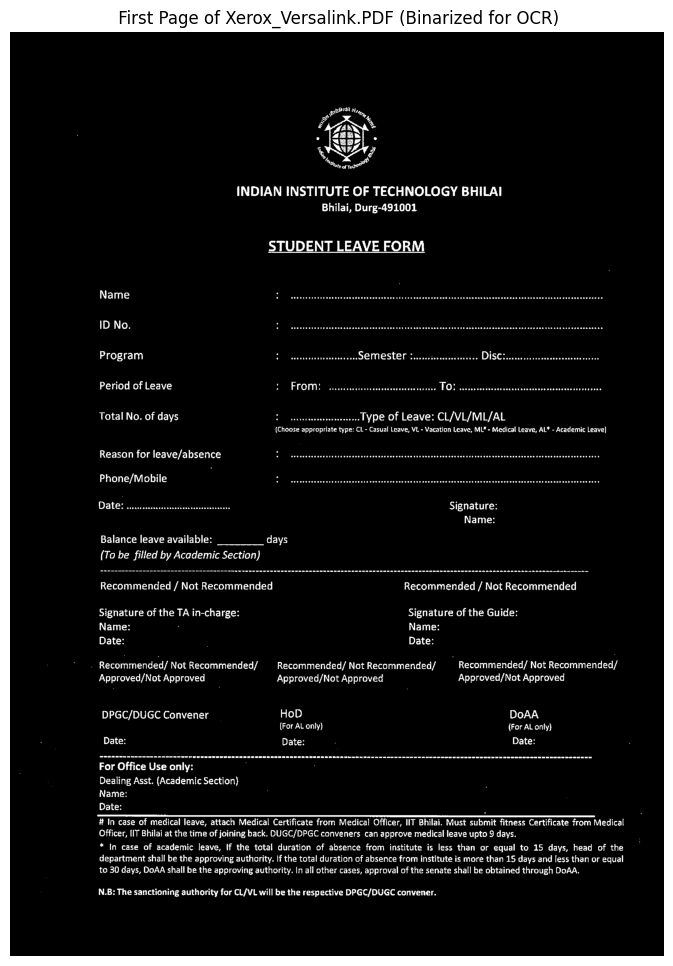

 Total 'e' in Xerox_Versalink.PDF: 253

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
   Page 1: 274 'e' characters


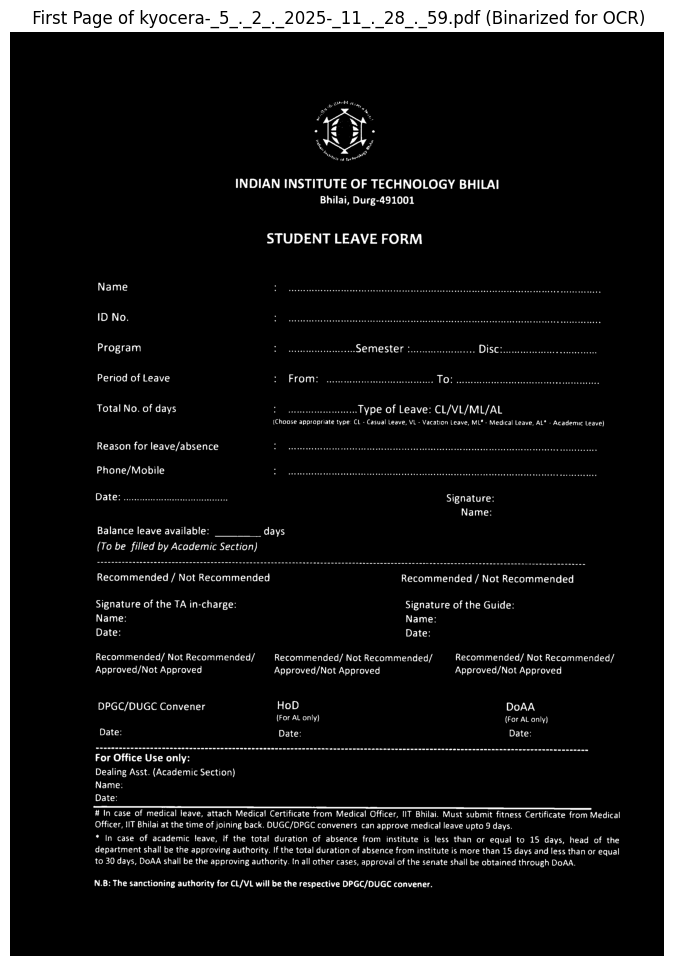

 Total 'e' in kyocera-_5_._2_._2025-_11_._28_._59.pdf: 274

 Processing: Brother.pdf
   Page 1: 308 'e' characters


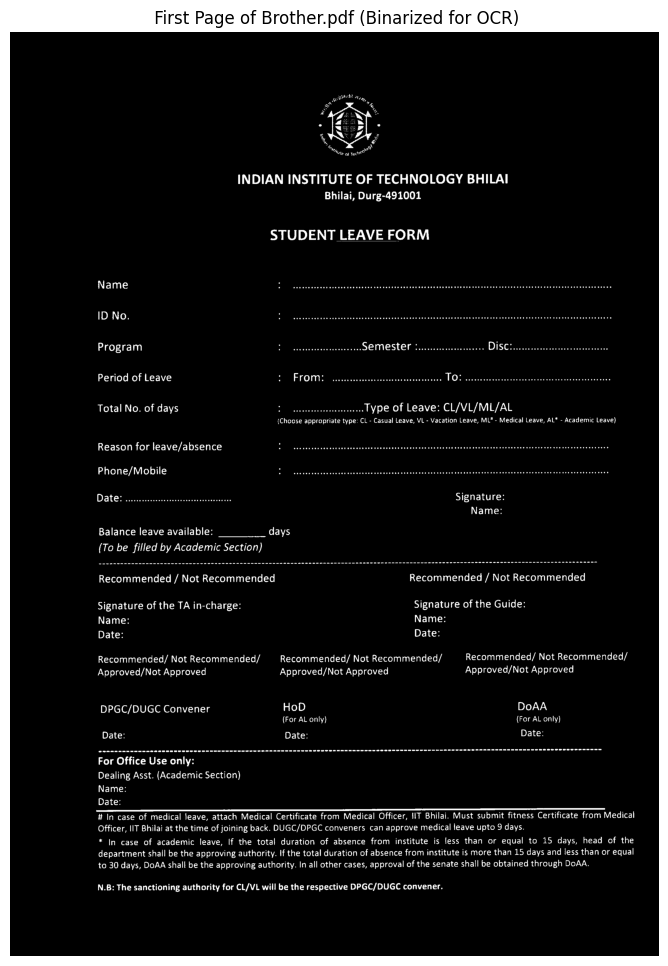

 Total 'e' in Brother.pdf: 308

 GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: 835


In [6]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")

def clean_and_list_pdfs(folder_path):
    pdf_files = []
    for filename in os.listdir(folder_path):
        full_path = os.path.join(folder_path, filename)
        if not os.path.isfile(full_path):
            continue
        name, ext = os.path.splitext(filename.strip())
        if ext.lower() == ".pdf":
            pdf_files.append(full_path)
    return pdf_files

def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

        config = r'--oem 3 --psm 6'
        text = pytesseract.image_to_string(binary, config=config)
        count_e = text.lower().count('e')

        print(f"   Page {i+1}: {count_e} 'e' characters")
        total_e += count_e

        if i == 0:
            plt.figure(figsize=(10, 12))
            plt.imshow(binary, cmap='gray')
            plt.title(f" First Page of {os.path.basename(pdf_path)} (Binarized for OCR)")
            plt.axis('off')
            plt.show()

    print(f" Total 'e' in {os.path.basename(pdf_path)}: {total_e}")
    return total_e

pdf_files = clean_and_list_pdfs(path)
print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)

grand_total_e = 0
for pdf in pdf_files:
    total_e = extract_character_e_from_pdf(pdf)
    grand_total_e += total_e
print(f"\n GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: {grand_total_e}")

 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
 Found 319 'e' characters on Page 1


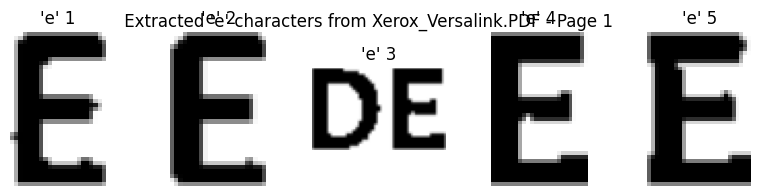


 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
 Found 218 'e' characters on Page 1


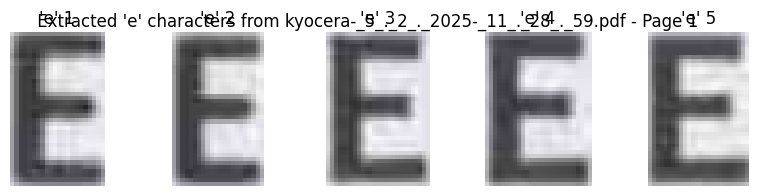


 Processing: Brother.pdf
 Found 258 'e' characters on Page 1


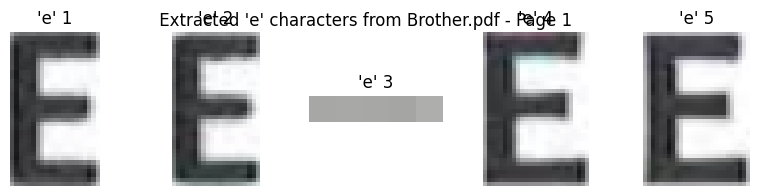

In [7]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")
def clean_and_list_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(".pdf") and os.path.isfile(os.path.join(folder_path, f))]

def extract_e_images(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")

    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return

    for i, page in enumerate(pages):
        image = np.array(page)
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        boxes = pytesseract.image_to_boxes(gray)
        h = image.shape[0]
        e_crops = []

        for b in boxes.splitlines():
            char, x1, y1, x2, y2, _ = b.split()
            if char.lower() == 'e':
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    e_crops.append(crop)

        if e_crops:
            print(f" Found {len(e_crops)} 'e' characters on Page {i+1}")
            plt.figure(figsize=(10, 2))
            for idx, crop in enumerate(e_crops[:5]):
                plt.subplot(1, min(5, len(e_crops)), idx + 1)
                plt.imshow(crop)
                plt.axis('off')
                plt.title(f"'e' {idx+1}")
            plt.suptitle(f" Extracted 'e' characters from {os.path.basename(pdf_path)} - Page {i+1}")
            plt.show()
        else:
            print(f" No 'e' characters found on Page {i+1}")

        break

pdf_files = clean_and_list_pdfs(path)
print(f"\n Found {len(pdf_files)} PDF file(s):")
for f in pdf_files:
    print("", f)

for pdf in pdf_files:
    extract_e_images(pdf)

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
 Found 319 'e' characters on Page 1
 Features for 'e' 1: {'contrast': np.float64(73.0070564516129), 'correlation': np.float64(0.9514026137901332), 'energy': np.float64(0.447759972067455), 'homogeneity': np.float64(0.7471073148744072)}
 Features for 'e' 2: {'contrast': np.float64(42.30947580645161), 'correlation': np.float64(0.9718417925711863), 'energy': np.float64(0.454201028264449), 'homogeneity': np.float64(0.772341278550831)}
 Features for 'e' 3: {'contrast': 

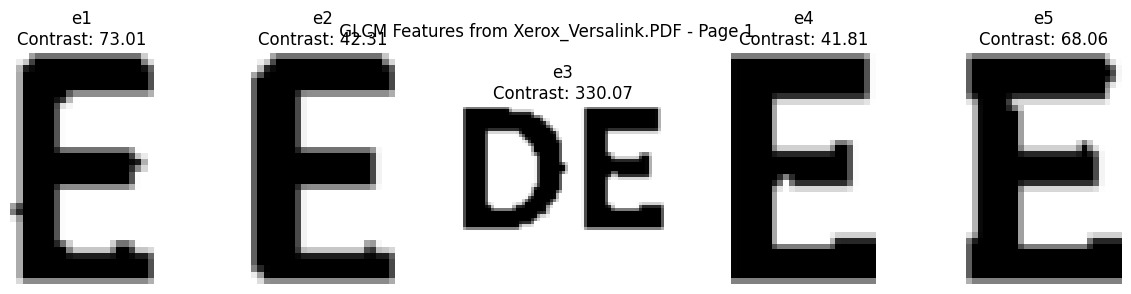

 Total 'e' characters in Xerox_Versalink.PDF: 319

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
 Found 217 'e' characters on Page 1
 Features for 'e' 1: {'contrast': np.float64(0.7469758064516128), 'correlation': np.float64(0.9938295510948306), 'energy': np.float64(0.1310735862869113), 'homogeneity': np.float64(0.720866935483871)}
 Features for 'e' 2: {'contrast': np.float64(13.203629032258064), 'correlation': np.float64(0.9749488395478545), 'energy': np.float64(0.09074820512037822), 'homogeneity': np.float64(0.486059667450381)}
 Features for 'e' 3: {'contrast': np.float64(12.561491935483872), 'correlation': np.float64(0.9759350438886676), 'energy': np.float64(0.09723773810624523), 'homogeneity': np.float64(0.5029409602108383)}
 Features for 'e' 4: {'contrast': np.float64(93.81552419354838), 'correlation': np.float64(0.837979061708824), 'energy': np.float64(0.07904151525771233), 'homogeneity': np.float64(0.3266550037236396)}
 Features for 'e' 5: {'contrast': np.float64(72.70161

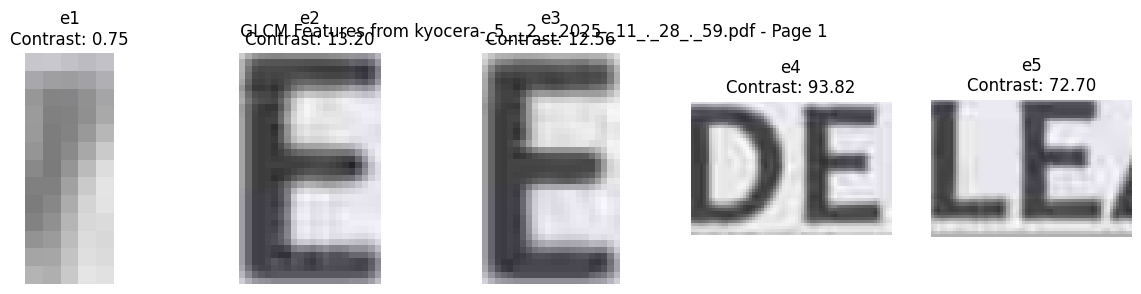

 Total 'e' characters in kyocera-_5_._2_._2025-_11_._28_._59.pdf: 217

 Processing: Brother.pdf
 Found 226 'e' characters on Page 1
 Features for 'e' 1: {'contrast': np.float64(14.996975806451614), 'correlation': np.float64(0.9814166406951513), 'energy': np.float64(0.12491054291167368), 'homogeneity': np.float64(0.5547444884569316)}
 Features for 'e' 2: {'contrast': np.float64(14.436491935483872), 'correlation': np.float64(0.9812240733505698), 'energy': np.float64(0.11197232881098276), 'homogeneity': np.float64(0.5516305770331786)}
 Features for 'e' 3: {'contrast': np.float64(0.12903225806451613), 'correlation': np.float64(0.9091554293825407), 'energy': np.float64(0.6251170545952891), 'homogeneity': np.float64(0.935483870967742)}
 Features for 'e' 4: {'contrast': np.float64(66.07358870967741), 'correlation': np.float64(0.8985266405979513), 'energy': np.float64(0.38355629510757516), 'homogeneity': np.float64(0.6475340082689667)}
 Features for 'e' 5: {'contrast': np.float64(80.0947580645

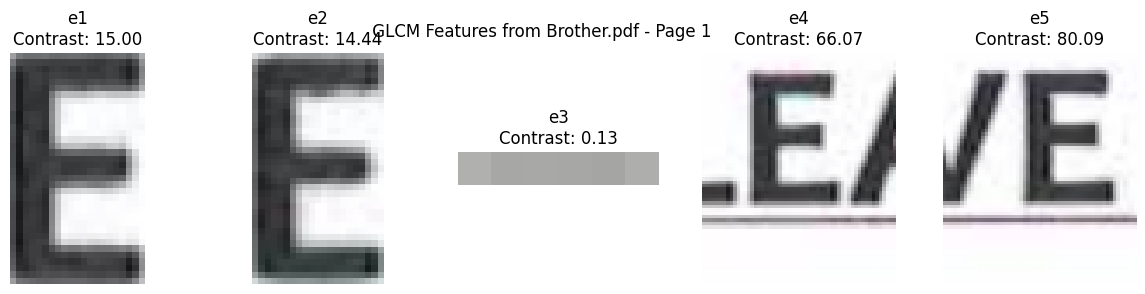

 Total 'e' characters in Brother.pdf: 226

 GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: 762


In [8]:
!pip install --upgrade scikit-image
!pip install kagglehub
!apt-get install -y poppler-utils tesseract-ocr
!pip install pytesseract pdf2image opencv-python pillow
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")
def clean_and_list_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(".pdf") and os.path.isfile(os.path.join(folder_path, f))]

def compute_glcm_features(image_crop):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (32, 32))
    gray = (gray / 4).astype(np.uint8)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0]
    }
    return features
def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        h, w, _ = image.shape

        boxes = pytesseract.image_to_boxes(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
        e_crops = []
        for b in boxes.splitlines():
            parts = b.split()
            if len(parts) < 6:
                continue
            char, x1, y1, x2, y2, _ = parts
            if char.lower() == 'e':
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    e_crops.append(crop)

        count_e = len(e_crops)
        total_e += count_e
        print(f" Found {count_e} 'e' characters on Page {i+1}")

        if e_crops:
            plt.figure(figsize=(15, 3))
            for idx, crop in enumerate(e_crops[:5]):
                features = compute_glcm_features(crop)
                plt.subplot(1, min(5, count_e), idx + 1)
                plt.imshow(cv2.cvtColor(crop, cv2.COLOR_BGR2RGB))
                plt.axis('off')
                plt.title(f"e{idx+1}\nContrast: {features['contrast']:.2f}")
                print(f" Features for 'e' {idx+1}: {features}")
            plt.suptitle(f" GLCM Features from {os.path.basename(pdf_path)} - Page {i+1}")
            plt.show()

    print(f" Total 'e' characters in {os.path.basename(pdf_path)}: {total_e}")
    return total_e


pdf_files = clean_and_list_pdfs(path)

print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)

grand_total_e = 0
for pdf in pdf_files:
    total_e = extract_character_e_from_pdf(pdf)
    grand_total_e += total_e

print(f"\n GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: {grand_total_e}")

 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
 Found 319 'e' characters on Page 1
 Total 'e' characters in Xerox_Versalink.PDF: 319

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
 Found 217 'e' characters on Page 1
 Total 'e' characters in kyocera-_5_._2_._2025-_11_._28_._59.pdf: 217

 Processing: Brother.pdf
 Found 226 'e' characters on Page 1
 Total 'e' characters in Brother.pdf: 226


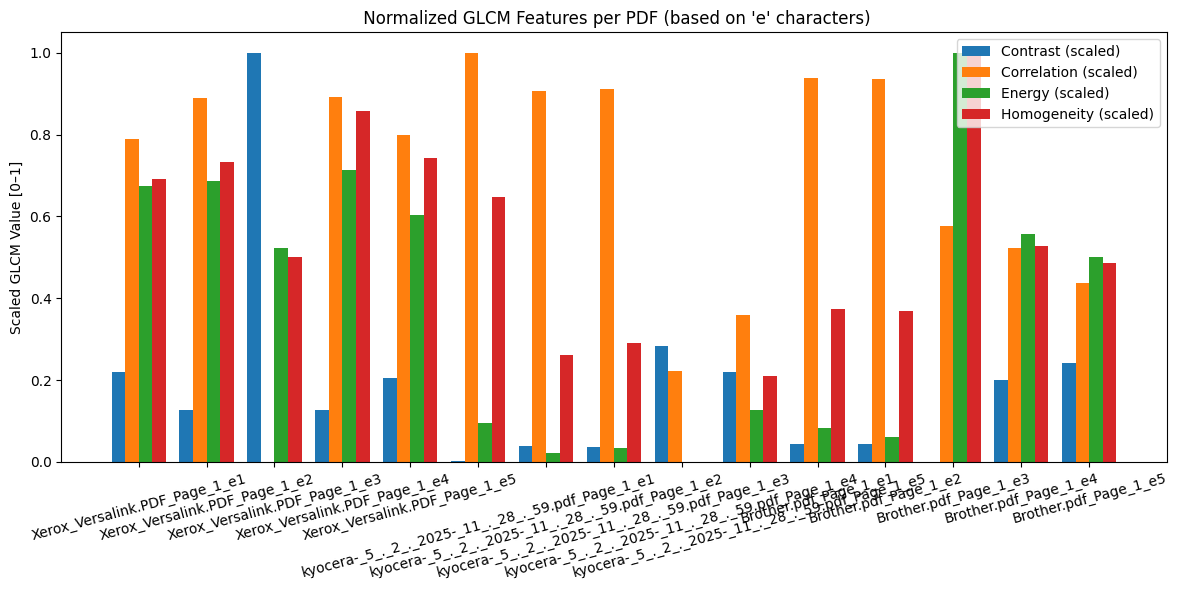


 GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: 60


In [9]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops


pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")

def clean_and_list_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(".pdf") and os.path.isfile(os.path.join(folder_path, f))]

def compute_glcm_features(image_crop):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (32, 32))
    gray = (gray / 4).astype(np.uint8)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0]
    }
    return features

def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0
    pdf_glcm_data = {}

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        h, w, _ = image.shape


        boxes = pytesseract.image_to_boxes(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        e_crops = []
        for b in boxes.splitlines():
            parts = b.split()
            if len(parts) < 6:
                continue
            char, x1, y1, x2, y2, _ = parts
            if char.lower() == 'e':
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    e_crops.append(crop)

        count_e = len(e_crops)
        total_e += count_e
        print(f" Found {count_e} 'e' characters on Page {i+1}")

        if e_crops:
            for idx, crop in enumerate(e_crops[:5]):
                features = compute_glcm_features(crop)
                pdf_glcm_data[f"{os.path.basename(pdf_path)}_Page_{i+1}_e{idx+1}"] = features

    print(f" Total 'e' characters in {os.path.basename(pdf_path)}: {total_e}")
    return pdf_glcm_data
def normalize(values):
    min_val, max_val = min(values), max(values)
    if max_val - min_val == 0:
        return [0.5 for _ in values]
    return [(v - min_val) / (max_val - min_val) for v in values]

pdf_files = clean_and_list_pdfs(path)
pdf_glcm_data = {}

print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)

for pdf in pdf_files:
    pdf_glcm_data.update(extract_character_e_from_pdf(pdf))

labels = list(pdf_glcm_data.keys())
contrast = [pdf_glcm_data[pdf]['contrast'] for pdf in labels]
correlation = [pdf_glcm_data[pdf]['correlation'] for pdf in labels]
energy = [pdf_glcm_data[pdf]['energy'] for pdf in labels]
homogeneity = [pdf_glcm_data[pdf]['homogeneity'] for pdf in labels]

contrast_norm = normalize(contrast)
correlation_norm = normalize(correlation)
energy_norm = normalize(energy)
homogeneity_norm = normalize(homogeneity)

x = np.arange(len(labels))
width = 0.2

plt.figure(figsize=(12, 6))
plt.bar(x - 1.5*width, contrast_norm, width, label='Contrast (scaled)')
plt.bar(x - 0.5*width, correlation_norm, width, label='Correlation (scaled)')
plt.bar(x + 0.5*width, energy_norm, width, label='Energy (scaled)')
plt.bar(x + 1.5*width, homogeneity_norm, width, label='Homogeneity (scaled)')

plt.ylabel('Scaled GLCM Value [0–1]')
plt.title(" Normalized GLCM Features per PDF (based on 'e' characters)")
plt.xticks(x, labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()

grand_total_e = sum(len(pdf_glcm_data[key]) for key in pdf_glcm_data)
print(f"\n GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: {grand_total_e}")

 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
 Found 319 'e' characters on Page 1
 Total 'e' characters in Xerox_Versalink.PDF: 319

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
 Found 217 'e' characters on Page 1
 Total 'e' characters in kyocera-_5_._2_._2025-_11_._28_._59.pdf: 217

 Processing: Brother.pdf
 Found 226 'e' characters on Page 1
 Total 'e' characters in Brother.pdf: 226


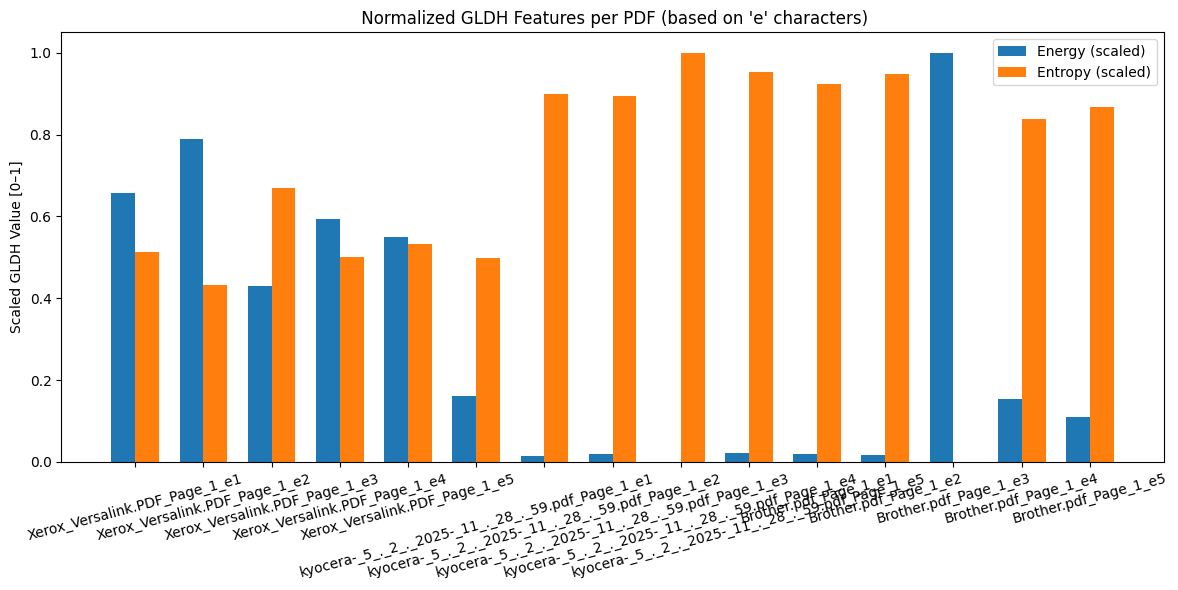


 GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: 30


In [12]:
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")

def clean_and_list_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(".pdf") and os.path.isfile(os.path.join(folder_path, f))]

def compute_gldh_features(image_crop):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (32, 32))

    max_gray_level = 256
    gldh = np.zeros(max_gray_level)

    for i in range(gray.shape[0] - 1):
        for j in range(gray.shape[1] - 1):
            diff = abs(int(gray[i, j]) - int(gray[i + 1, j + 1]))
            if diff < max_gray_level:
                gldh[diff] += 1

    gldh = gldh / np.sum(gldh)
    features = {
        'energy': np.sum(gldh ** 2),
        'entropy': -np.sum(gldh * np.log2(gldh + 1e-5))
    }
    return features

def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return 0

    total_e = 0
    pdf_gldh_data = {}

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        h, w, _ = image.shape

        boxes = pytesseract.image_to_boxes(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        e_crops = []
        for b in boxes.splitlines():
            parts = b.split()
            if len(parts) < 6:
                continue
            char, x1, y1, x2, y2, _ = parts
            if char.lower() == 'e':
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    e_crops.append(crop)

        count_e = len(e_crops)
        total_e += count_e
        print(f" Found {count_e} 'e' characters on Page {i+1}")

        if e_crops:
            for idx, crop in enumerate(e_crops[:5]):
                features = compute_gldh_features(crop)
                pdf_gldh_data[f"{os.path.basename(pdf_path)}_Page_{i+1}_e{idx+1}"] = features

    print(f" Total 'e' characters in {os.path.basename(pdf_path)}: {total_e}")
    return pdf_gldh_data

def normalize(values):
    min_val, max_val = min(values), max(values)
    if max_val - min_val == 0:
        return [0.5 for _ in values]
    return [(v - min_val) / (max_val - min_val) for v in values]

pdf_files = clean_and_list_pdfs(path)
pdf_gldh_data = {}

print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)

for pdf in pdf_files:
    pdf_gldh_data.update(extract_character_e_from_pdf(pdf))

labels = list(pdf_gldh_data.keys())
energy = [pdf_gldh_data[pdf]['energy'] for pdf in labels]
entropy = [pdf_gldh_data[pdf]['entropy'] for pdf in labels]

energy_norm = normalize(energy)
entropy_norm = normalize(entropy)

x = np.arange(len(labels))
width = 0.35
plt.figure(figsize=(12, 6))
plt.bar(x - width/2, energy_norm, width, label='Energy (scaled)')
plt.bar(x + width/2, entropy_norm, width, label='Entropy (scaled)')

plt.ylabel('Scaled GLDH Value [0–1]')
plt.title(" Normalized GLDH Features per PDF (based on 'e' characters)")
plt.xticks(x, labels, rotation=15)
plt.legend()
plt.tight_layout()
plt.show()
grand_total_e = sum(len(pdf_gldh_data[key]) for key in pdf_gldh_data)
print(f"\n GRAND TOTAL 'e' CHARACTERS IN ALL PDFs: {grand_total_e}")

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
 Dataset downloaded from KaggleHub

 Found 3 PDF file(s):
 /kaggle/input/cv-dataset/Xerox_Versalink.PDF
 /kaggle/input/cv-dataset/kyocera-_5_._2_._2025-_11_._28_._59.pdf
 /kaggle/input/cv-dataset/Brother.pdf

 Processing: Xerox_Versalink.PDF
 Found 319 'e' and 1434 non-'e' characters on Page 1

 Processing: kyocera-_5_._2_._2025-_11_._28_._59.pdf
 Found 217 'e' and 1314 non-'e' characters on Page 1

 Processing: Brother.pdf
 Found 226 'e' and 1309 non-'e' characters on Page 1
LDA Accuracy: 84.08%
LDA Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4057
           1       0.00      0.00      0.00       762

    accuracy     

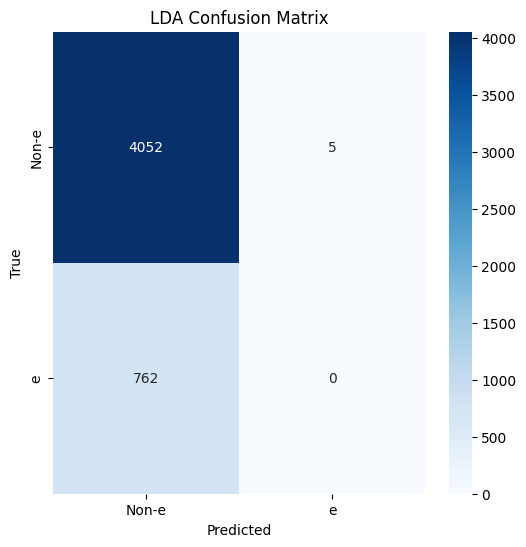

SVM Accuracy: 84.19%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.84      1.00      0.91      4057
           1       0.00      0.00      0.00       762

    accuracy                           0.84      4819
   macro avg       0.42      0.50      0.46      4819
weighted avg       0.71      0.84      0.77      4819



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


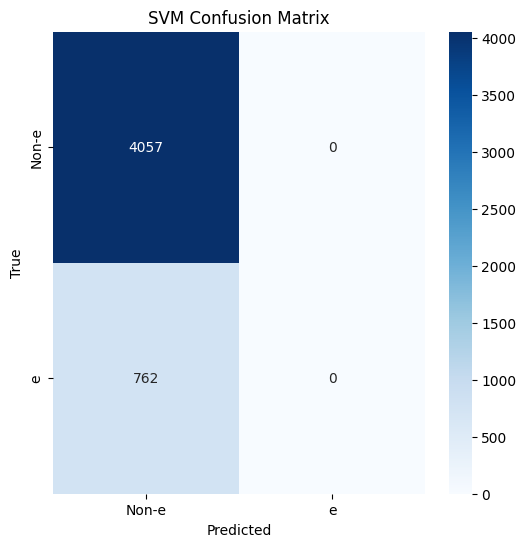

In [13]:
!pip install --upgrade scikit-image
!pip install kagglehub
!apt-get install -y poppler-utils tesseract-ocr
!pip install pytesseract pdf2image opencv-python pillow
import os
import cv2
import numpy as np
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
import matplotlib.pyplot as plt
from skimage.feature import graycomatrix, graycoprops
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'
path = kagglehub.dataset_download("nayanjain28/cv-dataset")
print(" Dataset downloaded from KaggleHub")

def clean_and_list_pdfs(folder_path):
    return [os.path.join(folder_path, f) for f in os.listdir(folder_path)
            if f.lower().endswith(".pdf") and os.path.isfile(os.path.join(folder_path, f))]

def compute_glcm_features(image_crop):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (32, 32))
    gray = (gray / 4).astype(np.uint8)

    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)

    features = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0]
    }
    return features

def extract_character_e_from_pdf(pdf_path):
    print(f"\n Processing: {os.path.basename(pdf_path)}")
    try:
        pages = convert_from_path(pdf_path, dpi=300)
    except Exception as e:
        print(f" Failed to convert PDF: {e}")
        return [], []

    e_features = []
    non_e_features = []

    for i, page in enumerate(pages):
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        h, w, _ = image.shape
        boxes = pytesseract.image_to_boxes(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        e_crops = []
        non_e_crops = []
        for b in boxes.splitlines():
            parts = b.split()
            if len(parts) < 6:
                continue
            char, x1, y1, x2, y2, _ = parts
            if char.lower() == 'e':
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    e_crops.append(crop)
            else:
                x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
                y1, y2 = h - y1, h - y2
                crop = image[y2:y1, x1:x2]
                if crop.size > 0:
                    non_e_crops.append(crop)

        for crop in e_crops:
            features = compute_glcm_features(crop)
            e_features.append(features)
        for crop in non_e_crops:
            features = compute_glcm_features(crop)
            non_e_features.append(features)

        print(f" Found {len(e_crops)} 'e' and {len(non_e_crops)} non-'e' characters on Page {i+1}")

    return e_features, non_e_features

def train_and_evaluate_models():
    e_features, non_e_features = [], []
    for pdf in pdf_files:
        e, non_e = extract_character_e_from_pdf(pdf)
        e_features.extend(e)
        non_e_features.extend(non_e)

    labels = [1] * len(e_features) + [0] * len(non_e_features)
    all_features = e_features + non_e_features

    X = np.array([list(f.values()) for f in all_features])
    y = np.array(labels)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    lda_predictions = lda.predict(X)
    lda_accuracy = accuracy_score(y, lda_predictions)
    print(f"LDA Accuracy: {lda_accuracy * 100:.2f}%")
    print("LDA Classification Report:")
    print(classification_report(y, lda_predictions))
    lda_cm = confusion_matrix(y, lda_predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(lda_cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-e", "e"], yticklabels=["Non-e", "e"])
    plt.title("LDA Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    svm = SVC(kernel='linear')
    svm.fit(X, y)
    svm_predictions = svm.predict(X)
    svm_accuracy = accuracy_score(y, svm_predictions)
    print(f"SVM Accuracy: {svm_accuracy * 100:.2f}%")
    print("SVM Classification Report:")
    print(classification_report(y, svm_predictions))
    svm_cm = confusion_matrix(y, svm_predictions)
    plt.figure(figsize=(6, 6))
    sns.heatmap(svm_cm, annot=True, fmt='d', cmap="Blues", xticklabels=["Non-e", "e"], yticklabels=["Non-e", "e"])
    plt.title("SVM Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

pdf_files = clean_and_list_pdfs(path)
print(f"\n Found {len(pdf_files)} PDF file(s):")
for file in pdf_files:
    print("", file)
train_and_evaluate_models()

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
poppler-utils is already the newest version (22.02.0-2ubuntu0.8).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.
 Found 3 PDF(s)
 LDA Accuracy: 84.08%
 SVM Accuracy: 84.19%


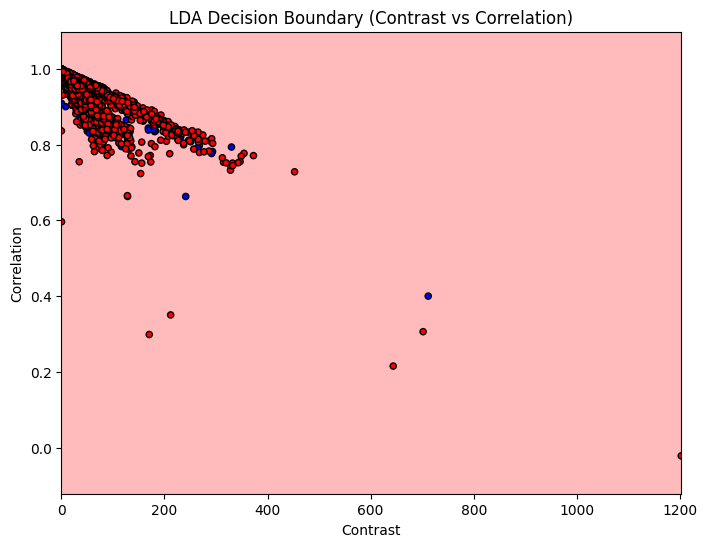

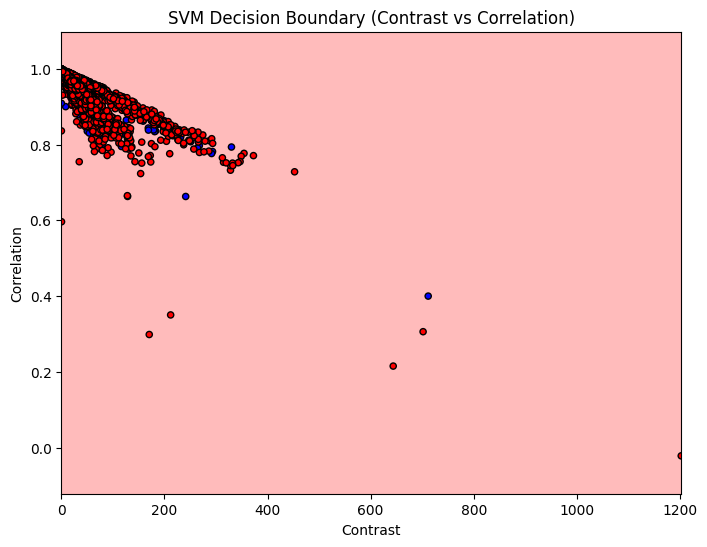

In [14]:
!pip install --quiet kagglehub scikit-image opencv-python pytesseract pdf2image
!apt-get install -y poppler-utils tesseract-ocr
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import pytesseract
from pdf2image import convert_from_path
import kagglehub
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import graycomatrix, graycoprops
from matplotlib.colors import ListedColormap
pytesseract.pytesseract.tesseract_cmd = '/usr/bin/tesseract'

def compute_glcm_features(image_crop):
    gray = cv2.cvtColor(image_crop, cv2.COLOR_RGB2GRAY)
    gray = cv2.resize(gray, (32, 32))
    gray = (gray / 4).astype(np.uint8)
    glcm = graycomatrix(gray, distances=[1], angles=[0], levels=64, symmetric=True, normed=True)
    return {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0]
    }

def extract_character_e_from_pdf(pdf_path):
    pages = convert_from_path(pdf_path, dpi=300)
    e_features, non_e_features = [], []

    for page in pages:
        image = cv2.cvtColor(np.array(page), cv2.COLOR_RGB2BGR)
        h, _, _ = image.shape
        boxes = pytesseract.image_to_boxes(Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))

        for b in boxes.splitlines():
            parts = b.split()
            if len(parts) < 6:
                continue
            char, x1, y1, x2, y2, _ = parts
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            y1, y2 = h - y1, h - y2
            crop = image[y2:y1, x1:x2]
            if crop.size > 0:
                features = compute_glcm_features(crop)
                if char.lower() == 'e':
                    e_features.append(features)
                else:
                    non_e_features.append(features)
    return e_features, non_e_features

def train_and_evaluate_models(pdf_files):
    e_features, non_e_features = [], []
    for pdf in pdf_files:
        e, non_e = extract_character_e_from_pdf(pdf)
        e_features.extend(e)
        non_e_features.extend(non_e)

    y = [1]*len(e_features) + [0]*len(non_e_features)
    X = np.array([list(f.values()) for f in (e_features + non_e_features)])
    y = np.array(y)

    lda = LinearDiscriminantAnalysis()
    lda.fit(X, y)
    print(" LDA Accuracy: {:.2f}%".format(accuracy_score(y, lda.predict(X)) * 100))

    svm = SVC(kernel='linear')
    svm.fit(X, y)
    print(" SVM Accuracy: {:.2f}%".format(accuracy_score(y, svm.predict(X)) * 100))

    return X, y, lda, svm

def plot_decision_boundaries(X, y, model, title):
    h = 0.01
    cmap_light = ListedColormap(['#FFAAAA', '#AAAAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#0000FF'])

    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap_bold, edgecolor='k', s=20)
    plt.xlabel("Contrast")
    plt.ylabel("Correlation")
    plt.title(title)
    plt.show()

path = kagglehub.dataset_download("nayanjain28/cv-dataset")
pdf_files = [os.path.join(path, f) for f in os.listdir(path) if f.lower().endswith(".pdf")]
print(f" Found {len(pdf_files)} PDF(s)")
X, y, lda, svm = train_and_evaluate_models(pdf_files)
X_2D = X[:, [0, 1]]
lda_2d = LinearDiscriminantAnalysis().fit(X_2D, y)
svm_2d = SVC(kernel='linear').fit(X_2D, y)

plot_decision_boundaries(X_2D, y, lda_2d, "LDA Decision Boundary (Contrast vs Correlation)")
plot_decision_boundaries(X_2D, y, svm_2d, "SVM Decision Boundary (Contrast vs Correlation)")

In [15]:
from scipy.stats import mode

lda_preds = lda.predict(X)
svm_preds = svm.predict(X)

combined_preds = np.vstack([lda_preds, svm_preds])
majority_preds, _ = mode(combined_preds, axis=0, keepdims=False)
accuracy = accuracy_score(y, majority_preds)
print(" Majority Voting Accuracy: {:.2f}%".format(accuracy * 100))
print("Classification Report:\n", classification_report(y, majority_preds))
print("Confusion Matrix:\n", confusion_matrix(y, majority_preds))

 Majority Voting Accuracy: 84.19%
Classification Report:
               precision    recall  f1-score   support

           0       0.84      1.00      0.91      4057
           1       0.00      0.00      0.00       762

    accuracy                           0.84      4819
   macro avg       0.42      0.50      0.46      4819
weighted avg       0.71      0.84      0.77      4819

Confusion Matrix:
 [[4057    0]
 [ 762    0]]


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [16]:
label_map = {0: 'e', 1: 'non-e'}
X_e = np.array([[v['contrast'], v['correlation'], v['energy'], v['homogeneity']]
                for v in pdf_glcm_data.values()])
keys_e = list(pdf_glcm_data.keys())

lda_preds = lda.predict(X_e)
svm_preds = svm.predict(X_e)

combined_preds = np.vstack([lda_preds, svm_preds])
majority_preds, _ = mode(combined_preds, axis=0, keepdims=False)

lda_preds_named = [label_map.get(p, p) for p in lda_preds]
svm_preds_named = [label_map.get(p, p) for p in svm_preds]
majority_preds_named = [label_map.get(p, p) for p in majority_preds]
import pandas as pd
results = pd.DataFrame({
    'Sample': keys_e,
    'LDA Prediction': lda_preds_named,
    'SVM Prediction': svm_preds_named,
    'Majority Vote': majority_preds_named
})
print(" Classification Results for Extracted 'e' Characters:")
print(results)

 Classification Results for Extracted 'e' Characters:
                                               Sample LDA Prediction  \
0                       Xerox_Versalink.PDF_Page_1_e1              e   
1                       Xerox_Versalink.PDF_Page_1_e2              e   
2                       Xerox_Versalink.PDF_Page_1_e3              e   
3                       Xerox_Versalink.PDF_Page_1_e4              e   
4                       Xerox_Versalink.PDF_Page_1_e5              e   
5   kyocera-_5_._2_._2025-_11_._28_._59.pdf_Page_1_e1              e   
6   kyocera-_5_._2_._2025-_11_._28_._59.pdf_Page_1_e2              e   
7   kyocera-_5_._2_._2025-_11_._28_._59.pdf_Page_1_e3              e   
8   kyocera-_5_._2_._2025-_11_._28_._59.pdf_Page_1_e4              e   
9   kyocera-_5_._2_._2025-_11_._28_._59.pdf_Page_1_e5              e   
10                              Brother.pdf_Page_1_e1              e   
11                              Brother.pdf_Page_1_e2              e   
12        